<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/intro_train_args.ipynb" 
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Controlling training & evaluation or 'what do all these agent.train(...) args mean ?' 

There are quite a few arguments you can pass to an agents `train(...)` method. Many start 
with `num_....` like `num_iterations` or `num_iteratons_between_eval`. 
They are used to control 

* the actual training - how often is the policy updated ? - as well as
* the evaluation of the current policy - how well does the currently trained policy actually perform ?

The training is performed in units called 'iterations'.
After each iteration the policy is updated.
At the beginning of an iteration data is collected by playing `num_episodes_per_iteration` games, which
are also called episodes. 
If an episodes runs for more than `max_steps_per_episode` steps, the episode is stopped and a new episode
is started (by calling the gym environments `reset()` method).

To see how the policy changes during training we evaluate the policy every `num_iterations_between_eval`
iterations. Since during evaluation the policy is not modified, we just use it to collect statistics
data like the average sum of rewards or the average number of steps per episode.

Thus a call to `agent.train(...)`results in a loop like this:

````
    initialize policy (typicallsy with random values)
    for i in range(num_iterations) 
        play num_episodes_per_iteration episodes using the current policy and store all steps
            if an episode runs for more than max_steps_per_episode steps stop the episode and start a new one
        update the current policy num_epochs_per_iteration times using the collected steps

        every num_iterations_between_eval iteration:
            play num_eval_episodes episodes and collect statistics like avg reward and avg steps
````

We can actually see how the train-loop runs:


### Install packages (gym, tfagents, tensorflow,....)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
else:
    #  for local installation
    sys.path.append('..')

#### install easyagents

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install easyagents >/dev/null    
    
import easyagents
easyagents.agents.seed=0

## The training loop in action

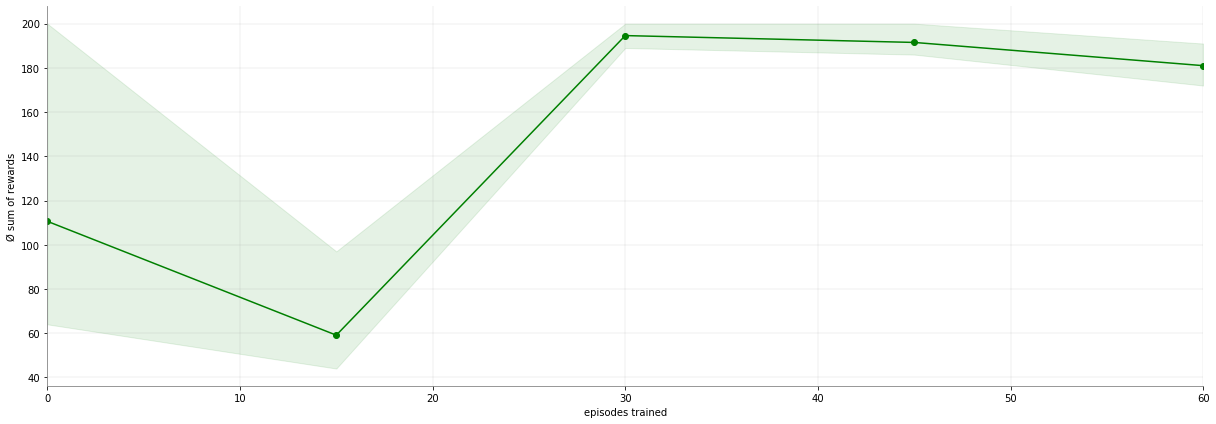

In [3]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log, plot

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([plot.Rewards()], num_iterations=20, num_episodes_per_iteration=3, 
                                 num_iterations_between_eval=5)

Note that
* the training ran for `60 = num_iterations * num_episodes_per_iteration` 
* every `15 = num_iterations_between_eval * num_episodes_per_iteration` a policy evaluation is performed. The average sum of rewards over all evaluated episodes is depicted as the 'green line'. The 'green shadow' depicts the min and max values encountered during the evaluation.

Using `num_episodes_per_eval` we can control the number of games played during each evaluation. Setting this to 1 means, that the min, max and average values must be equal and thus the 'green shadow' vanishs. Let's check this:

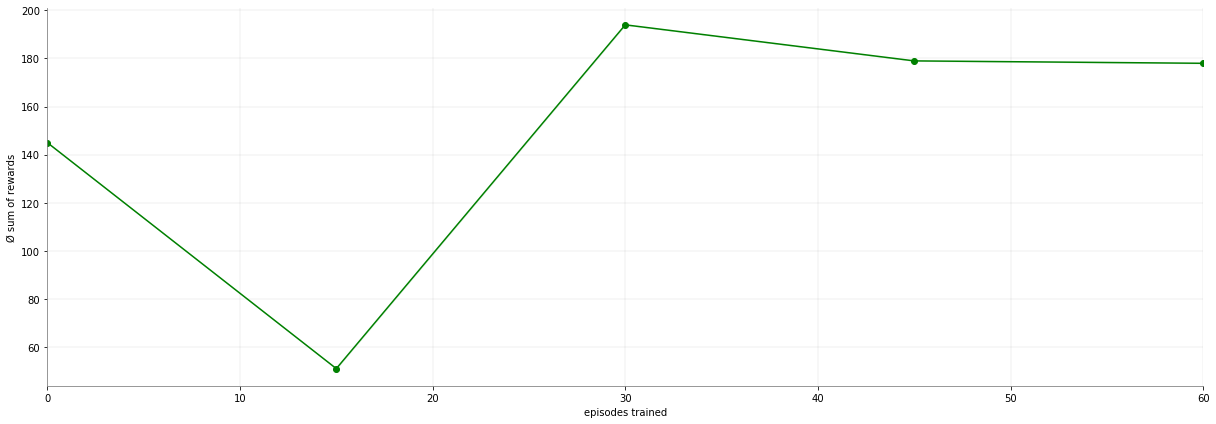

In [4]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log, plot

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([plot.Rewards()], num_iterations=20, num_episodes_per_iteration=3, 
                                 num_iterations_between_eval=5, num_episodes_per_eval=1)

If you would like to see the actual configuration of the `num_*`args use `log.Duartion()` ,
to add a log of the training loop use `log.Iteration()`:

In [5]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log, plot

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Duration(), log.Iteration()], default_plots=False,
                num_iterations=20, num_episodes_per_iteration=3, num_iterations_between_eval=5)

duration                 num_iterations=20 num_episodes_per_iteration=3 num_max_steps_per_episode=500 num_iterations_between_plot=2 num_iterations_between_eval=5 num_episodes_per_eval=10 
iteration 0  of 20       episodes_done=0   steps_done=0     rewards=(64.0,110.6,200.0) steps=(64.0,110.6,200.0) 
iteration 1  of 20       episodes_done=3   steps_done=59    loss=8473.8  [actor=-0.0    critic=8473.8 ] 
iteration 2  of 20       episodes_done=6   steps_done=114   loss=5276.3  [actor=0.0     critic=5276.2 ] 
iteration 3  of 20       episodes_done=9   steps_done=181   loss=7772.9  [actor=-0.0    critic=7772.9 ] 
iteration 4  of 20       episodes_done=12  steps_done=254   loss=10304.2 [actor=-0.0    critic=10304.2] 
iteration 5  of 20       episodes_done=15  steps_done=410   loss=37425.5 [actor=0.0     critic=37425.5] rewards=(44.0,59.1,97.0) steps=(44.0,59.1,97.0) 
iteration 6  of 20       episodes_done=18  steps_done=499   loss=14723.9 [actor=0.0     critic=14723.9] 
iteration 7  of 20   

<Figure size 1224x432 with 0 Axes>

If you would like to go even deeper and see the interaction between the agent and the gym environment
use `log.Step()`.

## Step based algorithms

Some algorithms do not collect data episode-wise (like PPO above), but just perform 1 or more steps and update the policy during a running game. Dqn is an example of a such an algorithm.

In Dqn we first play episodes for `num_steps_buffer_preload` steps and store each of them in a buffer.
In each iteration we collect data for `num_steps_per_iteration` steps and add them to the buffer.
For the actual policy update we then take `num_steps_sampled_from_buffer` steps from the buffer.

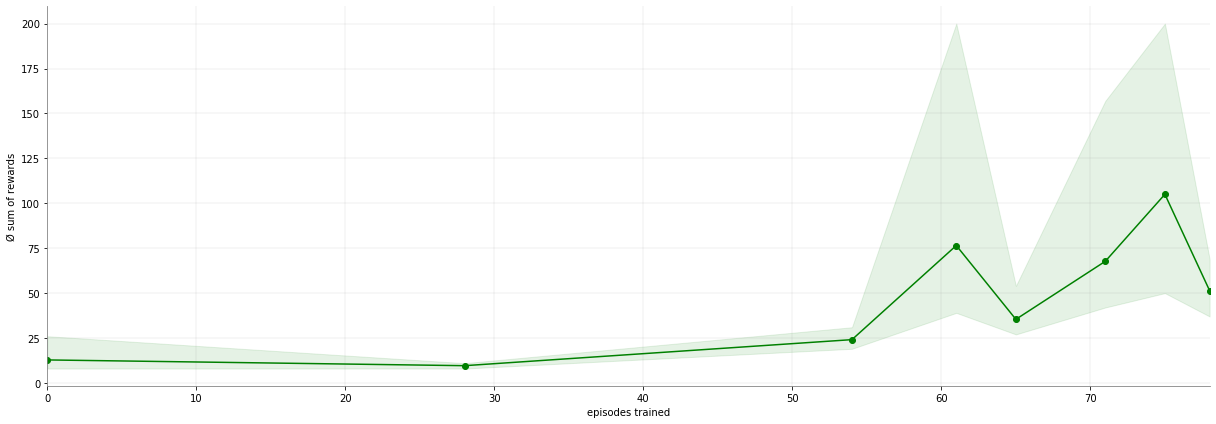

In [6]:
from easyagents.agents import DqnAgent
from easyagents.callbacks import duration, log, plot

dqnAgent = DqnAgent('CartPole-v0')
dqnAgent.train([plot.Rewards()], num_iterations=2000, num_steps_per_iteration=1, num_iterations_between_eval=300)

Note that
* since we take only 1 step per iteration, `num_iterations` is equal to the total number of steps taken during training 
* we define the length of an iteration in terms of steps, but plot the graphs in terms of episodes played. 
  Thus the number of episodes between 2 evaluations now depends on the current policy (which changes after each step).
  Initially the policy is very bad resulting in very short episodes and thus many episodes between 2 evaluations.
* as the policy improves during training, the number of steps per episode increases and the number of epsiodes
  between 2 evaluations shrinks.